# Plotting cycle to work times

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [18]:
import detective.core as detective
import detective.functions as functions
import pandas as pd

db = detective.db_from_hass_config()

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 296 entities with data


First we extract all state changes for Gaby and Charles

In [34]:
people = ("person.charles","person.gaby",)
workplaces = ("Imperial", "Harris Westminster",)
results = db.fetch_all_data_of(people)
results

The returned Pandas dataframe has 29943 rows of data.


,domain,entity_id,state,last_changed,attributes
0,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
1,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
2,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
3,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
4,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
...,...,...,...,...,...
29938,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."
29939,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."
29940,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."
29941,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."


In [27]:
results.state.unique()

array(['Imperial', 'Central london', 'Harris Westminster', 'not_home',
       'home', 'Wimbledon', 'Band practice', 'homea', 'test2', 'test',
       'RAL', 'South Wales', "Stef and John's", 'NPL'], dtype=object)

Let's collect all journeys made between home and work and plot their times. 

In [36]:
journeys = {}
for person in people:
    state_changes = results.loc[results.entity_id == person, ('state', 'last_changed')]
    # for i in range(state_changes.shape[0]):
    #     if state_changes.iloc[i, 
state_changes

,state,last_changed
54,Harris Westminster,2022-02-23 08:38:28.759979
55,Harris Westminster,2022-02-23 08:38:28.759979
56,Harris Westminster,2022-02-23 08:38:28.759979
57,Harris Westminster,2022-02-23 08:38:28.759979
58,Harris Westminster,2022-02-23 08:38:28.759979
...,...,...
29938,not_home,2021-11-30 07:51:31.218973
29939,not_home,2021-11-30 07:51:31.218973
29940,not_home,2021-11-30 07:51:31.218973
29941,not_home,2021-11-30 07:51:31.218973


At some point, I added Wimbledon as a location so that I could distuinguish between train and bike journeys. When was this?

In [19]:
df = pd.DataFrame.from_dict(results).fillna(0)
df

,domain,entity_id,state,last_changed,attributes
0,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
1,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
2,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
3,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
4,person,person.charles,Imperial,2022-02-23 09:00:09.403959,"{""editable"":false,""id"":""charles"",""latitude"":51..."
...,...,...,...,...,...
29935,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."
29936,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."
29937,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."
29938,person,person.gaby,not_home,2021-11-30 07:51:31.218973,"{""editable"":false,""id"":""gaby"",""latitude"":51.48..."


## View states
Detective makes it easy to view your state data as a pandas dataframe.

In [7]:
%%time

df = db.fetch_all_data_of(['sensor.dishwasher_energy_power'])

The returned Pandas dataframe has 50000 rows of data.
CPU times: user 6.72 s, sys: 14.7 s, total: 21.4 s
Wall time: 2min


Our data is now in a Pandas dataframe. Lets show the head of the dataframe:

In [8]:
df.head()

,domain,entity_id,state,last_changed,attributes
0,sensor,sensor.dishwasher_energy_power,0,2022-02-23 09:27:08.729268,"{""state_class"":""measurement"",""unit_of_measurem..."
1,sensor,sensor.dishwasher_energy_power,0,2022-02-23 09:26:48.753773,"{""state_class"":""measurement"",""unit_of_measurem..."
2,sensor,sensor.dishwasher_energy_power,0,2022-02-23 09:26:28.720051,"{""state_class"":""measurement"",""unit_of_measurem..."
3,sensor,sensor.dishwasher_energy_power,0,2022-02-23 09:26:08.775073,"{""state_class"":""measurement"",""unit_of_measurem..."
4,sensor,sensor.dishwasher_energy_power,0,2022-02-23 09:25:48.762835,"{""state_class"":""measurement"",""unit_of_measurem..."


It is necessary to do some formatting of the data before we can plot it, and detective provides several functions to assist. You should familiarise yourself with these functions and create your own.

In [9]:
df = functions.generate_features(df)
df = functions.format_dataframe(df)
df = df.set_index('last_changed')

In [10]:
df.head()

,domain,entity_id,state,attributes,device_class,unit_of_measurement,friendly_name
last_changed,,,,,,,
2022-02-23 09:27:08.729268,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-02-23 09:26:48.753773,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-02-23 09:26:28.720051,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-02-23 09:26:08.775073,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power
2022-02-23 09:25:48.762835,sensor,sensor.dishwasher_energy_power,0,"{'state_class': 'measurement', 'unit_of_measur...",power,W,Dishwasher ENERGY Power


Notice the new feature columns added. It is straightforward to create your own features, for example to add a day_of_week column

<AxesSubplot:xlabel='last_changed'>

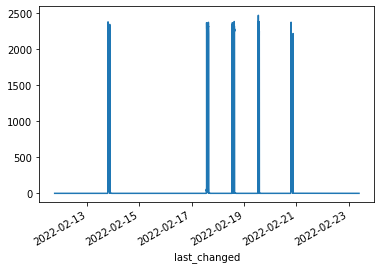

In [11]:
df['state'].plot()

## Plot some data
First plot using [Seaborn](https://seaborn.pydata.org/)

In [12]:
#!pip install seaborn # Uncomment to install if required

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

<AxesSubplot:xlabel='last_changed', ylabel='state'>

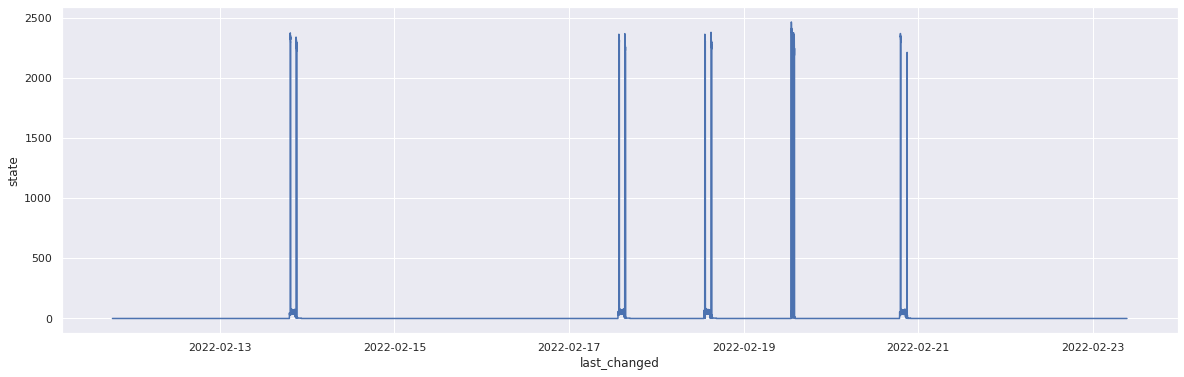

In [13]:
fig, ax = plt.subplots(1, figsize=(20,6))
sns.lineplot(data=df['state'])

In [14]:
# !pip install pandas-bokeh

In [15]:
from bokeh.plotting import figure
import pandas_bokeh
pandas_bokeh.output_notebook()

ModuleNotFoundError: No module named 'pandas_bokeh'

In [ ]:
df.plot_bokeh()

In [ ]:
df['mode'] = ''

In [ ]:
df.loc[df['state'] < 1, 'mode'] = 'off'
df.loc[(1 <= df['state']) & (df['state'] < 10), 'mode'] = 'standby'
df.loc[(df['state'] >= 10), 'mode'] = 'running'

In [ ]:
df[df['mode'] == 'off']['state'].head()

In [ ]:
p = pd.DataFrame({
    'off' : df.loc[df['mode'] == 'off', 'state'],
    'running' : df.loc[df['mode'] == 'running', 'state'],
    'standby' : df.loc[df['mode'] == 'standby', 'state'],
})
p.plot_bokeh()

In [ ]:
p.loc[~p['off'].isna(), 'off'] = 0
p.loc[~p['standby'].isna(), 'standby'] = 1
p.loc[~p['running'].isna(), 'running'] = 2
fig, ax = plt.subplots(1, figsize=(20,6))
sns.scatterplot(data=p)